# CNN_Plant_Seedling_Classification


此範例會使用模組化的軟體設計方法，它將一個大型的程式或專案拆分成更小、更容易管理的模塊或組件。每個模塊執行特定的功能或處理特定的任務，並且可以獨立開發、測試和維護。這樣的設計有助於提高程式碼的可讀性、可重用性和可維護性，並且讓不同團隊的開發者能夠協作更輕鬆。在PyTorch中，模組化通常表現為創建獨立的模型、函數和類別，每個模塊負責特定的任務，並且可以輕鬆組合在一起以構建更大的深度學習模型。

本次課程將會把pytorch訓練流程分成以下幾個模組來教學:
1. `Dataset`
2. `Dataloader`
3. `Model`
4. `Train` Function
5. `Valid` Function
6. `Plot Curve` Function
7. `Predict` Function
8. `Main` Function
9. `Addition` Customize model

## Download Datasets

此範例使用kaggle上的[Plant Seedlings Classification](https://www.kaggle.com/c/plant-seedlings-classification)資料集，請先至網站中下載`plant-seedlings-classification.zip`，透過`google.colab`套件，我們可以讓 Colab 上的程式直接讀取自己的雲端硬碟。


執行下面的code之前，請先確保自己的google drive中已經有`plant-seedlings-classification.zip`檔案，並確保檔案位置正確。

掛載自己的google drive後，雲端硬碟的根目錄為: `/content/gdrive/MyDrive/`



In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
data_dir = "/workspace/g12415170/ML/ML_HW1/"

'''
import zipfile
from google.colab import drive

drive.mount('/content/gdrive')
data_dir = '/content/gdrive/MyDrive/Colab Notebooks/plant_seedlings_classification/' # dataset's dir you want to unzip

if not os.path.exists(data_dir):
  zip_dir = '/content/gdrive/MyDrive/Colab Notebooks/plant-seedlings-classification.zip' # your zip file's dir

  with zipfile.ZipFile(zip_dir, 'r') as zip_ref:
      zip_ref.extractall(data_dir)
'''

"\nimport zipfile\nfrom google.colab import drive\n\ndrive.mount('/content/gdrive')\ndata_dir = '/content/gdrive/MyDrive/Colab Notebooks/plant_seedlings_classification/' # dataset's dir you want to unzip\n\nif not os.path.exists(data_dir):\n  zip_dir = '/content/gdrive/MyDrive/Colab Notebooks/plant-seedlings-classification.zip' # your zip file's dir\n\n  with zipfile.ZipFile(zip_dir, 'r') as zip_ref:\n      zip_ref.extractall(data_dir)\n"

## Import Package

In [2]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

from torchvision import models
from torchvision.utils import make_grid
from torchvision import transforms as tsfm
from torchvision.datasets import ImageFolder

import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
from pathlib import Path
from IPython import display

# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.backends.cudnn.deterministic = True

## Config
Config of Hyperparameter

In [3]:
# Set Hyperparameters
batch_size = 64
epochs = 50
learning_rate = 0.001
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

## 1. Custom Pytorch Dataset


A `Dataset` in Pytorch should have three methods:

1. `__init__`: Read data & preprocess
2. `__len__`: return a integer indicating the size of the dataset
3. `__getitem__`: given an index `idx`, return the `idx`-th sample

In our case, the download data is structured as:
```
├── train
│   ├── Black-grass (Class name)
│   │   ├── 0050f38b3.png
│   │   ├── 0183fdf68.png
│   │   ├── 0260cffa8.png
│   │   ├── ...
│   └── Charlock
│   │   ├── 022179d65.png
│   │   ├── 02c95e601.png
│   │   ├── 04098447d.png
│   │   ├── ...
│   └── ...
├── test
│   ├── 0021e90e4.png
│   ├── 003d61042.png
│   ├── 007b3da8b.png
│   ├── ...
```

We can simply find all the pngs and load them into memory when needed. In common practice, dataset will receive one or more `torchvision.transforms` which transform the png (loaded as `PIL.Image`) into pytorch tensor.

`Dataloader` batchify the samples in dataset, i.e. builds mini-batch from the data return by dataset's `__getitem__` . We then iterate the `Dataloader` for training.

Usually `Dataloader` is finite and will run of mini-batches when we have seen all samples in `Dataset` once. However, to write our code easily, we can create an infinite `Sampler` that can guide the batchification process in `Dataloader` and make `Dataloader` supply mini-batches infinitely.

In [4]:
class Train_data(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = ImageFolder(root=root_dir, transform=transform)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        return img, label

class Pred_data(Dataset):
    def __init__(self, root_dir, transform=None):
        self.img_paths = list(Path(root_dir).glob('*.png'))
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx])
        img = self.transform(img)
        img = img.unsqueeze(0)
        return img

train_dir = [/workspace/g12415170/ML/ML_HW1/train]


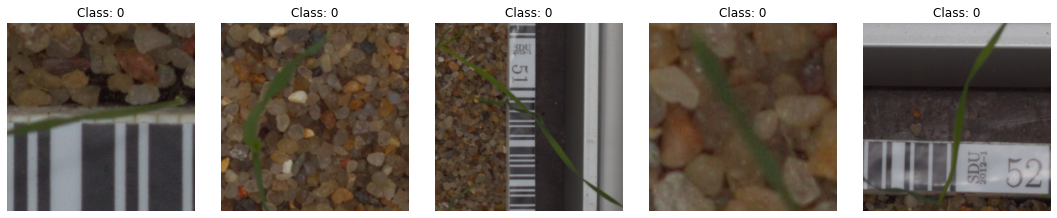

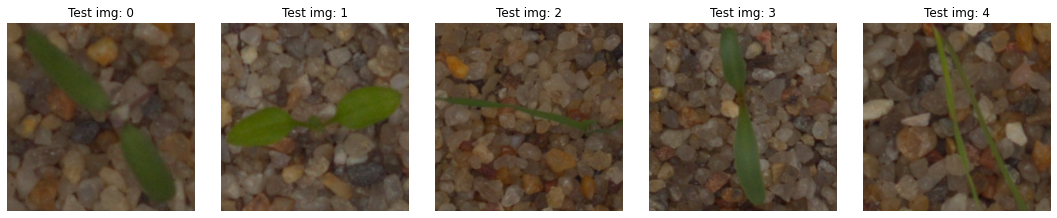

In [5]:
# visualize dataset item for debug
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
transform = tsfm.Compose([
    tsfm.Resize((224, 224)),
    tsfm.ToTensor(),
])

print('train_dir = [' + train_dir + ']')

whole_set = Train_data(
    root_dir=train_dir,
    transform=transform
)

test_set = Pred_data(
    root_dir=test_dir,
    transform=transform
)

num_images_to_display = 5
fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 3))

for i, (img, label) in enumerate(whole_set):
    axs[i].imshow(img.permute(1, 2, 0))
    axs[i].set_title(f'Class: {label}')
    axs[i].axis('off')

    num_images_to_display -= 1
    if num_images_to_display == 0:
        break

plt.tight_layout()
plt.show()

num_images_to_display = 5
fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 3))
for i, img in enumerate(test_set):
    axs[i].imshow(img[0].permute(1, 2, 0))
    axs[i].set_title(f'Test img: {i}')
    axs[i].axis('off')

    num_images_to_display -= 1
    if num_images_to_display == 0:
        break

plt.tight_layout()
plt.show()

## 2. Split train, valid set and Create Dataloader:


In [6]:
train_size = int(0.8 * len(whole_set))
valid_size = len(whole_set) - train_size

train_set, valid_set = random_split(whole_set, [train_size, valid_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

## 3. Create Model

A `nn.Module` in Pytorch should have two methods:

1. `__init__`: Initialize your model & define layers
2. `forward`: Compute output of your Model



In [7]:
class resnet_50(nn.Module):
    def __init__(self, num_classes = 12):
        super(resnet_50, self).__init__()
        # pytorch built-in models
        self.resnet50 = models.resnet50(pretrained= True)

        # set model layers trainable
        for param in self.resnet50.parameters():
            param.requires_grad = True

        # redifine/customize last classification layer
        self.resnet50.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.resnet50(x)
        return x

In [8]:
# test model for debug

model = resnet_50(num_classes=12).cuda()
# print(model)
x = torch.rand(1, 3, 224, 224).cuda()
y = model(x)
print(x)
print(y)

tensor([[[[0.6671, 0.7646, 0.2732,  ..., 0.2299, 0.8501, 0.7446],
          [0.3145, 0.1770, 0.4947,  ..., 0.2657, 0.5151, 0.2777],
          [0.9626, 0.3276, 0.1024,  ..., 0.8075, 0.6732, 0.5020],
          ...,
          [0.1053, 0.0563, 0.9618,  ..., 0.0177, 0.8644, 0.9249],
          [0.2369, 0.6065, 0.7551,  ..., 0.8097, 0.0856, 0.5755],
          [0.6274, 0.9982, 0.7637,  ..., 0.2613, 0.3500, 0.0402]],

         [[0.5232, 0.1650, 0.3030,  ..., 0.7249, 0.3848, 0.7339],
          [0.5719, 0.4828, 0.7574,  ..., 0.5348, 0.9477, 0.0841],
          [0.2502, 0.2524, 0.9801,  ..., 0.1184, 0.5851, 0.6820],
          ...,
          [0.9749, 0.6790, 0.7742,  ..., 0.9642, 0.1267, 0.7451],
          [0.0856, 0.5820, 0.4309,  ..., 0.6179, 0.5303, 0.8151],
          [0.7269, 0.7204, 0.1821,  ..., 0.2500, 0.2649, 0.3273]],

         [[0.0077, 0.6897, 0.1437,  ..., 0.5420, 0.3801, 0.0750],
          [0.3946, 0.1692, 0.3127,  ..., 0.4402, 0.9574, 0.0358],
          [0.8982, 0.4166, 0.9354,  ..., 0

## 4. Define Train Function(for one epoch):


In [9]:
def train(model, criterion, optimizer, train_loader, epoch, total_epochs, batch_size):
    model.train()
    train_loss, train_acc = [], []

    tqdm_iter = tqdm(train_loader, desc="Epoch: {}/{} ({}%) | Training loss: NaN".format(
    epoch, total_epochs, int(epoch/total_epochs * 100)), leave=False)
    epoch_loss, epoch_acc = 0.0, 0.0
    for batch_idx, (data, label) in enumerate(tqdm_iter):
        data, target = data.cuda(), label.cuda()
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == target).float().mean().item()
        epoch_loss += loss.item()
        epoch_acc += acc

        tqdm_iter.set_description("Epoch: {}/{} ({}%) | Training loss: {:.6f} | Training Acc: {:.6f}".format(
        epoch + 1, total_epochs, int((epoch+1)/total_epochs * 100), round(loss.item(), 6), round(acc, 6)))

    return epoch_loss / len(train_loader), epoch_acc / len(train_loader)

In [10]:
# debug "train" function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

loss, acc = train(
    model,
    criterion,
    optimizer,
    train_loader,
    epoch=1,
    total_epochs=1,
    batch_size=batch_size
)

print(loss, acc)

Epoch: 1/1 (100%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

2.8570103804270426 0.12361111113180717


## 5. Define Valid Function(for one epoch):


In [11]:
def valid(model, criterion, valid_loader, epoch, total_epochs, batch_size):
    model.eval()

    tqdm_iter = tqdm(valid_loader, desc="Epoch: {}/{} ({}%) | Valid loss: NaN".format(
    epoch, total_epochs, int(epoch/total_epochs * 100)), leave=False)
    epoch_loss, epoch_acc = 0.0, 0.0
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(tqdm_iter):
            data, target = data.cuda(), label.cuda()
            output = model(data)
            loss = criterion(output, target)
            acc = (output.argmax(dim=1) == target).float().mean().item()
            epoch_loss += loss.item()
            epoch_acc += acc

            tqdm_iter.set_description("Epoch: {}/{} ({}%) | Valid loss: {:.6f} | Valid Acc: {:.6f}".format(
            epoch + 1, total_epochs, int((epoch+1)/total_epochs * 100), round(loss.item(), 6), round(acc, 6)))

    return epoch_loss / len(valid_loader), epoch_acc / len(valid_loader)

In [12]:
# debug "valid" function
criterion = nn.CrossEntropyLoss()
loss, acc = valid(
    model,
    criterion,
    valid_loader,
    epoch=1,
    total_epochs=1,
    batch_size=batch_size
)

print(loss, acc)

Epoch: 1/1 (100%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

2.5518726825714113 0.13024691343307496


## 6. Plot Learning Curve Function:

In [13]:
def Plot(title, ylabel, epochs, train_loss, valid_loss):
    plt.figure()
    plt.title(title)
    plt.xlabel('epochs')
    plt.ylabel(ylabel)
    plt.plot(epochs, train_loss)
    plt.plot(epochs, valid_loss)
    plt.legend(['train', 'valid'], loc='upper left')

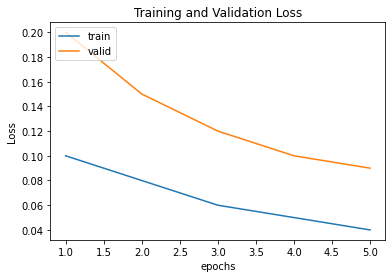

In [14]:
# debug "Plot" function
debug_epochs = [1, 2, 3, 4, 5]
debug_train_loss = [0.1, 0.08, 0.06, 0.05, 0.04]
debug_valid_loss = [0.2, 0.15, 0.12, 0.1, 0.09]

Plot("Training and Validation Loss", 'Loss', debug_epochs, debug_train_loss, debug_valid_loss)

plt.show()

## 7. Predict Function:

In [15]:
def predict(loader, model):
    model.eval()
    preds = []
    for data in tqdm(loader):
        pred = model(data.cuda())
        cls = torch.argmax(pred, dim=1)
        preds.append(cls)

    return preds

In [16]:
# Visualize Predict result
def view_pred_result(preds, num_images_to_display=5):
    labels = ['Black-grass', 'Charlock' , 'Cleavers' , 'Common Chickweed' , 'Common wheat' , 'Fat Hen' , 'Loose Silky-bent' , 'Maize' , 'Scentless Mayweed' , 'Shepherds Purse', 'Small-flowered Cranesbill' , 'Sugar beet']
    fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 3))
    for i, img in enumerate(test_set):
        axs[i].imshow(img[0].permute(1, 2, 0))
        axs[i].set_title(labels[preds[i].item()])
        axs[i].axis('off')

        num_images_to_display -= 1
        if num_images_to_display == 0:
            break

    plt.tight_layout()
    plt.show()

  0%|          | 0/794 [00:00<?, ?it/s]

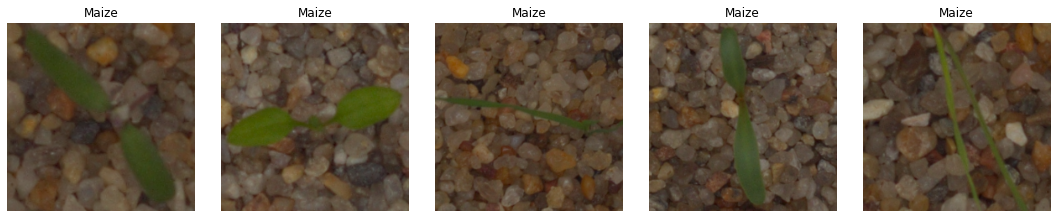

In [17]:
# debug "Predict" function & "View_Predict_result" function
test_dir = data_dir + '/test'
transform = tsfm.Compose([
    tsfm.Resize((224, 224)),
    tsfm.ToTensor(),
])
test_set = Pred_data(
    root_dir=test_dir,
    transform=transform
)
model = resnet_50(num_classes=12).cuda()

preds = predict(test_set, model)
view_pred_result(preds)

## 8. Main Function(training pipeline):
1. `Set Hyperparameters`: `batct_size`, `learning rate`, `epochs`...
2. `Initial`: initial `dataset`, `dataloader`, `model`
3. `Train`: Do train
4. `Valid`: Do valid
5. repeat `3.`  `4.` epochs times
6. `Plot curve`: Plot learning curve to observe the learning progress
7. `Predict`: Use the trained model to predict the results of the test set

50


Epoch: 0/50 (0%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 4.262296315034231, Avg train acc: 0.13541666666666666


Epoch: 0/50 (0%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.439033619562785, Avg valid acc: 0.1304398149251938


Epoch: 1/50 (2%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.337612493832906, Avg train acc: 0.18741319452722868


Epoch: 1/50 (2%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.3167064746220905, Avg valid acc: 0.15933641990025837


Epoch: 2/50 (4%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.9974343180656433, Avg train acc: 0.30130208333333336


Epoch: 2/50 (4%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.7659906546274822, Avg valid acc: 0.36913580099741616


Epoch: 3/50 (6%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.7361201286315917, Avg train acc: 0.4192708333333333


Epoch: 3/50 (6%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.6361452658971152, Avg valid acc: 0.42955246766408284


Epoch: 4/50 (8%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.5218859434127807, Avg train acc: 0.4791666666666667


Epoch: 4/50 (8%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.5312809626261392, Avg valid acc: 0.5415123462677002


Epoch: 5/50 (10%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.448985121647517, Avg train acc: 0.5157118062178294


Epoch: 5/50 (10%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.380317489306132, Avg valid acc: 0.5988040129343669


Epoch: 6/50 (12%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.3461829523245494, Avg train acc: 0.5450520833333333


Epoch: 6/50 (12%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.334187642733256, Avg valid acc: 0.5667824069658915


Epoch: 7/50 (14%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.2483632067839305, Avg train acc: 0.5706597228844961


Epoch: 7/50 (14%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.2481807390848796, Avg valid acc: 0.599189813931783


Epoch: 8/50 (16%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.1482452283302942, Avg train acc: 0.608940972884496


Epoch: 8/50 (16%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.047229250272115, Avg valid acc: 0.35547839601834613


Epoch: 9/50 (18%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.1665065358082454, Avg train acc: 0.6151041666666667


Epoch: 9/50 (18%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.100175408522288, Avg valid acc: 0.6451388875643412


Epoch: 10/50 (20%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.1144383649031322, Avg train acc: 0.629079861442248


Epoch: 10/50 (20%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.1258335749308268, Avg valid acc: 0.6597993850708008


Epoch: 11/50 (22%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.0596052000919978, Avg train acc: 0.639409722884496


Epoch: 11/50 (22%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.0148312409718832, Avg valid acc: 0.6822530865669251


Epoch: 12/50 (24%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.0602799654006958, Avg train acc: 0.6409722228844961


Epoch: 12/50 (24%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.492693336804708, Avg valid acc: 0.5233024676640828


Epoch: 13/50 (26%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.9716432044903437, Avg train acc: 0.6722222228844961


Epoch: 13/50 (26%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.04287109375, Avg valid acc: 0.6924768527348836


Epoch: 14/50 (28%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.9249397536118825, Avg train acc: 0.6907118062178293


Epoch: 14/50 (28%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.9217564225196838, Avg valid acc: 0.7329089522361756


Epoch: 15/50 (30%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.9591977337996165, Avg train acc: 0.6815972228844961


Epoch: 15/50 (30%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.3006457090377808, Avg valid acc: 0.5565586407979329


Epoch: 16/50 (32%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.9656035661697387, Avg train acc: 0.6821180562178294


Epoch: 16/50 (32%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.2763332366943358, Avg valid acc: 0.5711419741312663


Epoch: 17/50 (34%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.9011073033014934, Avg train acc: 0.7000868062178294


Epoch: 17/50 (34%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.019366478919983, Avg valid acc: 0.7030864199002583


Epoch: 18/50 (36%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.8368511915206909, Avg train acc: 0.7269097228844961


Epoch: 18/50 (36%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.9163346807161967, Avg valid acc: 0.7084876537322998


Epoch: 19/50 (38%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.8246452798446019, Avg train acc: 0.7165798614422481


Epoch: 19/50 (38%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.9130721251169841, Avg valid acc: 0.7127314805984497


Epoch: 20/50 (40%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.8272333100438118, Avg train acc: 0.7221354166666667


Epoch: 20/50 (40%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.8872282942136128, Avg valid acc: 0.7405864199002584


Epoch: 21/50 (42%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.7747378235061964, Avg train acc: 0.7396701395511627


Epoch: 21/50 (42%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.101133926709493, Avg valid acc: 0.6302469134330749


Epoch: 22/50 (44%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.7695965652664503, Avg train acc: 0.7482638895511627


Epoch: 22/50 (44%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.839428981145223, Avg valid acc: 0.7297839522361755


Epoch: 23/50 (46%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.6994891797502836, Avg train acc: 0.7694444447755814


Epoch: 23/50 (46%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.7676890969276429, Avg valid acc: 0.7643518527348836


Epoch: 24/50 (48%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.6871280814210574, Avg train acc: 0.7789930562178294


Epoch: 24/50 (48%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.0772067705790203, Avg valid acc: 0.6501157402992248


Epoch: 25/50 (50%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.7130145212014516, Avg train acc: 0.7582465281089147


Epoch: 25/50 (50%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.8633295774459839, Avg valid acc: 0.747878086566925


Epoch: 26/50 (52%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.7034922078251838, Avg train acc: 0.760329861442248


Epoch: 26/50 (52%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.8010392864545186, Avg valid acc: 0.7676697532335918


Epoch: 27/50 (54%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.6747351169586182, Avg train acc: 0.7789930562178294


Epoch: 27/50 (54%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.7430686354637146, Avg valid acc: 0.7845293203989665


Epoch: 28/50 (56%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.6430716837445895, Avg train acc: 0.7847222223877907


Epoch: 28/50 (56%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.7662710944811503, Avg valid acc: 0.7824459870656332


Epoch: 29/50 (57%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.6299001827836037, Avg train acc: 0.791753472884496


Epoch: 29/50 (57%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.69867817958196, Avg valid acc: 0.805748458703359


Epoch: 30/50 (60%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.6298668429255485, Avg train acc: 0.7934027781089147


Epoch: 30/50 (60%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.7908637881278991, Avg valid acc: 0.741435186068217


Epoch: 31/50 (62%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.5931877215703328, Avg train acc: 0.7943576395511627


Epoch: 31/50 (62%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.9844109257062276, Avg valid acc: 0.6718364199002583


Epoch: 32/50 (64%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.6362120380004247, Avg train acc: 0.7901041666666667


Epoch: 32/50 (64%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.9233179608980815, Avg valid acc: 0.6609953721364339


Epoch: 33/50 (66%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.5820479129751523, Avg train acc: 0.8027777781089147


Epoch: 33/50 (66%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.6767619808514913, Avg valid acc: 0.7993055542310079


Epoch: 34/50 (68%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.6145295165479183, Avg train acc: 0.7942708333333334


Epoch: 34/50 (68%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.8692498524983724, Avg valid acc: 0.7224922855695088


Epoch: 35/50 (70%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.5579976866642634, Avg train acc: 0.8122395833333333


Epoch: 35/50 (70%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.6883454541365306, Avg valid acc: 0.7878472208976746


Epoch: 36/50 (72%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.4955007789035638, Avg train acc: 0.8311631947755813


Epoch: 36/50 (72%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.7481801311175028, Avg valid acc: 0.7777006189028423


Epoch: 37/50 (74%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.5180432560543219, Avg train acc: 0.823784722884496


Epoch: 37/50 (74%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.5714021543661754, Avg valid acc: 0.841936727364858


Epoch: 38/50 (76%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.5637191956241926, Avg train acc: 0.8082465281089147


Epoch: 38/50 (76%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.655911773443222, Avg valid acc: 0.8095293203989665


Epoch: 39/50 (78%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.5139337812860807, Avg train acc: 0.8268229166666666


Epoch: 39/50 (78%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.6840147892634074, Avg valid acc: 0.7939043203989665


Epoch: 40/50 (80%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.45890962754686676, Avg train acc: 0.8430555562178293


Epoch: 40/50 (80%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.5462959706783295, Avg valid acc: 0.8194830258687337


Epoch: 41/50 (82%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.4655920376380285, Avg train acc: 0.8427951395511627


Epoch: 41/50 (82%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.5260866304238637, Avg valid acc: 0.8422067920366924


Epoch: 42/50 (84%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.5158330279091994, Avg train acc: 0.826909722884496


Epoch: 42/50 (84%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.6230521420637767, Avg valid acc: 0.8273533940315246


Epoch: 43/50 (86%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.48705911661187806, Avg train acc: 0.8348090281089147


Epoch: 43/50 (86%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.659910382827123, Avg valid acc: 0.805748458703359


Epoch: 44/50 (88%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.4886586591601372, Avg train acc: 0.8348090281089147


Epoch: 44/50 (88%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.6270971258481344, Avg valid acc: 0.7949459870656331


Epoch: 45/50 (90%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.4451185672233502, Avg train acc: 0.8488715281089146


Epoch: 45/50 (90%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.6991940359274547, Avg valid acc: 0.7898533940315247


Epoch: 46/50 (92%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.4724758185446262, Avg train acc: 0.8463541666666666


Epoch: 46/50 (92%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.8276604652404785, Avg valid acc: 0.7305555542310079


Epoch: 47/50 (94%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.4412979575494925, Avg train acc: 0.8494791666666667


Epoch: 47/50 (94%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.5898881673812866, Avg valid acc: 0.8207175930341085


Epoch: 48/50 (96%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.4095372699201107, Avg train acc: 0.855642361442248


Epoch: 48/50 (96%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.6467712601025899, Avg valid acc: 0.7903935194015503


Epoch: 49/50 (98%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.42226911212007207, Avg train acc: 0.8639756947755813


Epoch: 49/50 (98%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.6586756308873495, Avg valid acc: 0.8093364199002584


  0%|          | 0/794 [00:00<?, ?it/s]

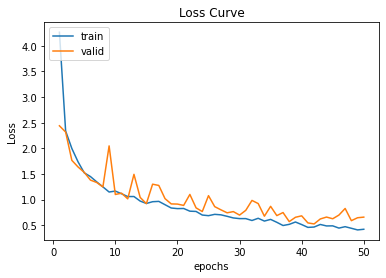

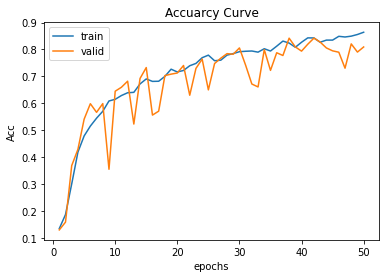

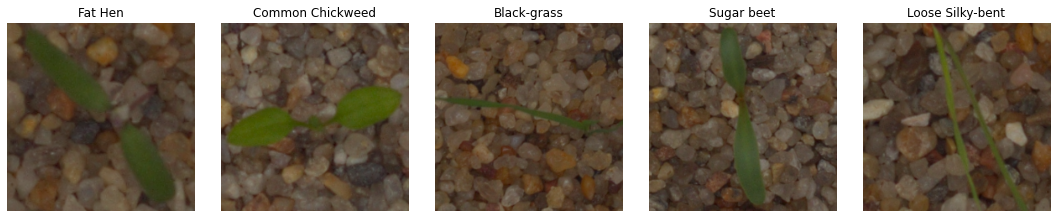

In [21]:
def main():
    # initial transform
    transform = tsfm.Compose([
        tsfm.Resize((224, 224)),
        tsfm.ToTensor(),
    ])

    # initial dataset
    whole_set = Train_data(
        root_dir=train_dir,
        transform=transform
    )

    test_set = Pred_data(
        root_dir=test_dir,
        transform=transform
    )

    # split train valid and initial dataloader
    train_set_size = int(len(whole_set) * 0.8)
    valid_set_size = len(whole_set) - train_set_size
    train_set, valid_set = random_split(whole_set, [train_set_size, valid_set_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size)

    # initial model
    model = VGG16(num_classes=12).cuda()

    # initial loss_function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # initial plot values
    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []
    epoch_list = []

    # repeat train and valid epochs times
    print(epochs)
    for epoch in range(epochs):
      epoch_list.append(epoch + 1)

      loss, acc = train(
          model,
          criterion,
          optimizer,
          train_loader,
          epoch=epoch,
          total_epochs=epochs,
          batch_size=batch_size
      )
      train_loss.append(loss)
      train_acc.append(acc)
      print(f'Avg train Loss: {loss}, Avg train acc: {acc}')

      loss, acc = valid(
          model,
          criterion,
          valid_loader,
          epoch=epoch,
          total_epochs=epochs,
          batch_size=batch_size
      )
      valid_loss.append(loss)
      valid_acc.append(acc)
      print(f'Avg valid Loss: {loss}, Avg valid acc: {acc}')

    Plot("Loss Curve", 'Loss', epoch_list, train_loss, valid_loss)
    Plot("Accuarcy Curve", 'Acc', epoch_list, train_acc, valid_acc)

    preds = predict(test_set, model)
    view_pred_result(preds)

main()

## 9. Addition: Customize your own model
Create your own deep learning model, by define the inner layers in hand-craft<br>
Example for VGG16 model: https://arxiv.org/abs/1409.1556

In [22]:
class VGG16(nn.Module):
    def __init__(self, num_classes=12):
        super(VGG16, self).__init__()
        # input layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())

        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        #  classifier
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU()
        )

        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU()
        )

        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [23]:
# Test model to debug
x = torch.rand(1, 3, 224, 224)
model = VGG16(num_classes=12)
y = model(x)
print(y)

tensor([[-0.4090,  0.0664, -0.0996, -0.4749,  0.1941,  0.1621,  0.0917, -0.1029,
          0.0927,  0.1447,  0.2921, -0.1605]], grad_fn=<AddmmBackward0>)


Rerun training for VGG16 model

50


Epoch: 0/50 (0%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 4.249170005321503, Avg train acc: 0.11927083333333334


Epoch: 0/50 (0%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4537320295969645, Avg valid acc: 0.12361111144224803


Epoch: 1/50 (2%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.478113309542338, Avg train acc: 0.132465277860562


Epoch: 1/50 (2%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.448623037338257, Avg valid acc: 0.12758487661679585


Epoch: 2/50 (4%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.4550731897354128, Avg train acc: 0.13428819452722868


Epoch: 2/50 (4%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4284757455190022, Avg valid acc: 0.14861111144224803


Epoch: 3/50 (6%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.425965142250061, Avg train acc: 0.127951388930281


Epoch: 3/50 (6%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4452037175496417, Avg valid acc: 0.12731481492519378


Epoch: 4/50 (8%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.4201431314150494, Avg train acc: 0.12135416666666667


Epoch: 4/50 (8%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4320826371510824, Avg valid acc: 0.1440586417913437


Epoch: 5/50 (10%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.415603991349538, Avg train acc: 0.1342881944651405


Epoch: 5/50 (10%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4329766432444253, Avg valid acc: 0.14510030845801036


Epoch: 6/50 (12%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.415024697780609, Avg train acc: 0.13203125


Epoch: 6/50 (12%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4313925584157308, Avg valid acc: 0.14510030845801036


Epoch: 7/50 (14%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.414087112744649, Avg train acc: 0.134375


Epoch: 7/50 (14%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.432668685913086, Avg valid acc: 0.14510030845801036


Epoch: 8/50 (16%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.415490138530731, Avg train acc: 0.13524305559694766


Epoch: 8/50 (16%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4378409385681152, Avg valid acc: 0.14510030845801036


Epoch: 9/50 (18%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.413152205944061, Avg train acc: 0.13932291666666666


Epoch: 9/50 (18%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.432522980372111, Avg valid acc: 0.11755401293436686


Epoch: 10/50 (20%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.415657937526703, Avg train acc: 0.13090277779847384


Epoch: 10/50 (20%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4359046459197997, Avg valid acc: 0.14510030845801036


Epoch: 11/50 (22%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.4178020040194195, Avg train acc: 0.13524305572112402


Epoch: 11/50 (22%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4298067569732664, Avg valid acc: 0.14510030845801036


Epoch: 12/50 (24%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.4154869675636292, Avg train acc: 0.1303819444651405


Epoch: 12/50 (24%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4322051843007406, Avg valid acc: 0.11755401293436686


Epoch: 13/50 (26%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.413393513361613, Avg train acc: 0.13550347238779067


Epoch: 13/50 (26%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.430949672063192, Avg valid acc: 0.14510030845801036


Epoch: 14/50 (28%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.4167335589726764, Avg train acc: 0.13324652779847385


Epoch: 14/50 (28%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4334421316782633, Avg valid acc: 0.11755401293436686


Epoch: 15/50 (30%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.4140178044637044, Avg train acc: 0.133420138930281


Epoch: 15/50 (30%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4317970434824625, Avg valid acc: 0.11755401293436686


Epoch: 16/50 (32%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.414386097590129, Avg train acc: 0.13663194452722868


Epoch: 16/50 (32%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4319385369618733, Avg valid acc: 0.14510030845801036


Epoch: 17/50 (34%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.410640378793081, Avg train acc: 0.13038194452722868


Epoch: 17/50 (34%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4308985551198323, Avg valid acc: 0.14510030845801036


Epoch: 18/50 (36%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.413482701778412, Avg train acc: 0.13133680572112402


Epoch: 18/50 (36%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4313116391499836, Avg valid acc: 0.14510030845801036


Epoch: 19/50 (38%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.417518941561381, Avg train acc: 0.13220486113180716


Epoch: 19/50 (38%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4314895153045653, Avg valid acc: 0.14510030845801036


Epoch: 20/50 (40%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.4147488951683043, Avg train acc: 0.123871527860562


Epoch: 20/50 (40%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.430888271331787, Avg valid acc: 0.14510030845801036


Epoch: 21/50 (42%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.41353786389033, Avg train acc: 0.13767361119389535


Epoch: 21/50 (42%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.433560784657796, Avg valid acc: 0.11755401293436686


Epoch: 22/50 (44%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.413908048470815, Avg train acc: 0.1256944444651405


Epoch: 22/50 (44%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4332071940104165, Avg valid acc: 0.11755401293436686


Epoch: 23/50 (46%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.414284853140513, Avg train acc: 0.136371527860562


Epoch: 23/50 (46%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4299801349639893, Avg valid acc: 0.14510030845801036


Epoch: 24/50 (48%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.4144138932228087, Avg train acc: 0.13567708333333334


Epoch: 24/50 (48%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.431347147623698, Avg valid acc: 0.14510030845801036


Epoch: 25/50 (50%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.413635273774465, Avg train acc: 0.12751736113180717


Epoch: 25/50 (50%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.431342856089274, Avg valid acc: 0.14510030845801036


Epoch: 26/50 (52%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.4133756875991823, Avg train acc: 0.13159722226361434


Epoch: 26/50 (52%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4312684377034506, Avg valid acc: 0.14510030845801036


Epoch: 27/50 (54%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.4145143906275432, Avg train acc: 0.13671875


Epoch: 27/50 (54%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.433198340733846, Avg valid acc: 0.11755401293436686


Epoch: 28/50 (56%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.413538138071696, Avg train acc: 0.13142361119389534


Epoch: 28/50 (56%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4313956260681153, Avg valid acc: 0.14510030845801036


Epoch: 29/50 (57%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.4131680488586427, Avg train acc: 0.13385416666666666


Epoch: 29/50 (57%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4323745727539063, Avg valid acc: 0.11755401293436686


Epoch: 30/50 (60%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.414217249552409, Avg train acc: 0.138368055721124


Epoch: 30/50 (60%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4328308582305906, Avg valid acc: 0.14510030845801036


Epoch: 31/50 (62%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.4140780091285707, Avg train acc: 0.13524305559694766


Epoch: 31/50 (62%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.433726453781128, Avg valid acc: 0.14510030845801036


Epoch: 32/50 (64%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.416143079598745, Avg train acc: 0.13142361113180717


Epoch: 32/50 (64%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4322059790293378, Avg valid acc: 0.14510030845801036


Epoch: 33/50 (66%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.413643109798431, Avg train acc: 0.13151041666666666


Epoch: 33/50 (66%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4305105845133466, Avg valid acc: 0.14510030845801036


Epoch: 34/50 (68%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.4145156502723695, Avg train acc: 0.13524305559694766


Epoch: 34/50 (68%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4325485865275067, Avg valid acc: 0.14510030845801036


Epoch: 35/50 (70%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.413134586811066, Avg train acc: 0.13611111119389535


Epoch: 35/50 (70%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.432654698689779, Avg valid acc: 0.14510030845801036


Epoch: 36/50 (72%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.4129324078559877, Avg train acc: 0.13159722238779067


Epoch: 36/50 (72%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4321225325266522, Avg valid acc: 0.14510030845801036


Epoch: 37/50 (74%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.4120091835657758, Avg train acc: 0.13697916666666668


Epoch: 37/50 (74%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4321319421132404, Avg valid acc: 0.14510030845801036


Epoch: 38/50 (76%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.4134783228238423, Avg train acc: 0.13524305559694766


Epoch: 38/50 (76%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.431371243794759, Avg valid acc: 0.14510030845801036


Epoch: 39/50 (78%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.4133418440818786, Avg train acc: 0.13081597226361433


Epoch: 39/50 (78%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4327592690785727, Avg valid acc: 0.14510030845801036


Epoch: 40/50 (80%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.4140520373980205, Avg train acc: 0.132465277860562


Epoch: 40/50 (80%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.432408825556437, Avg valid acc: 0.14510030845801036


Epoch: 41/50 (82%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.4147549152374266, Avg train acc: 0.13072916666666667


Epoch: 41/50 (82%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4318837324778237, Avg valid acc: 0.14510030845801036


Epoch: 42/50 (84%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.4129559795061746, Avg train acc: 0.12934027786056201


Epoch: 42/50 (84%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4304134686787924, Avg valid acc: 0.14510030845801036


Epoch: 43/50 (86%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.416117250919342, Avg train acc: 0.13472222226361433


Epoch: 43/50 (86%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4306500275929768, Avg valid acc: 0.14510030845801036


Epoch: 44/50 (88%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.4124006708463033, Avg train acc: 0.13229166666666667


Epoch: 44/50 (88%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.431225045522054, Avg valid acc: 0.14510030845801036


Epoch: 45/50 (90%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.4133802533149717, Avg train acc: 0.13298611119389533


Epoch: 45/50 (90%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4307544072469076, Avg valid acc: 0.14510030845801036


Epoch: 46/50 (92%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.412691005071004, Avg train acc: 0.13611111119389535


Epoch: 46/50 (92%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4329076608022056, Avg valid acc: 0.14510030845801036


Epoch: 47/50 (94%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.414161988099416, Avg train acc: 0.13524305559694766


Epoch: 47/50 (94%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.432163715362549, Avg valid acc: 0.14510030845801036


Epoch: 48/50 (96%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.412394917011261, Avg train acc: 0.1359375


Epoch: 48/50 (96%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.430581267674764, Avg valid acc: 0.11755401293436686


Epoch: 49/50 (98%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.415783421198527, Avg train acc: 0.128125


Epoch: 49/50 (98%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.4302379290262857, Avg valid acc: 0.14510030845801036


  0%|          | 0/794 [00:00<?, ?it/s]

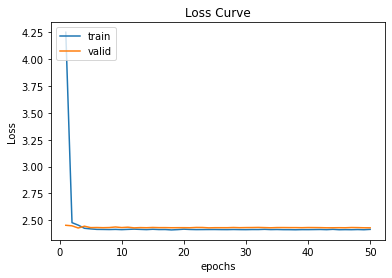

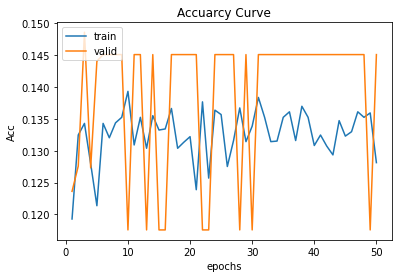

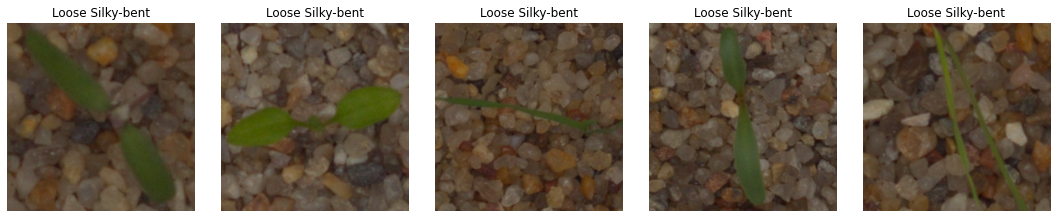

In [24]:
def main():
    # initial transform
    transform = tsfm.Compose([
        tsfm.Resize((224, 224)),
        tsfm.ToTensor(),
    ])

    # initial dataset
    whole_set = Train_data(
        root_dir=train_dir,
        transform=transform
    )

    test_set = Pred_data(
        root_dir=test_dir,
        transform=transform
    )

    # split train valid and initial dataloader
    train_set_size = int(len(whole_set) * 0.8)
    valid_set_size = len(whole_set) - train_set_size
    train_set, valid_set = random_split(whole_set, [train_set_size, valid_set_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size)

    # initial model
    model = VGG16(num_classes=12).cuda()

    # initial loss_function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # initial plot values
    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []
    epoch_list = []

    # repeat train and valid epochs times
    print(epochs)
    for epoch in range(epochs):
      epoch_list.append(epoch + 1)

      loss, acc = train(
          model,
          criterion,
          optimizer,
          train_loader,
          epoch=epoch,
          total_epochs=epochs,
          batch_size=batch_size
      )
      train_loss.append(loss)
      train_acc.append(acc)
      print(f'Avg train Loss: {loss}, Avg train acc: {acc}')

      loss, acc = valid(
          model,
          criterion,
          valid_loader,
          epoch=epoch,
          total_epochs=epochs,
          batch_size=batch_size
      )
      valid_loss.append(loss)
      valid_acc.append(acc)
      print(f'Avg valid Loss: {loss}, Avg valid acc: {acc}')

    Plot("Loss Curve", 'Loss', epoch_list, train_loss, valid_loss)
    Plot("Accuarcy Curve", 'Acc', epoch_list, train_acc, valid_acc)

    preds = predict(test_set, model)
    view_pred_result(preds)

main()